## Load Data

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

NUM_CLASSES = 10
INPUT_SIZE = 784

In [3]:

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(y_train)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[5 0 4 ... 5 6 8]


## Data Visualization

4


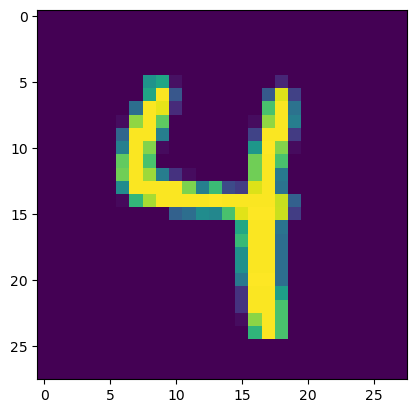

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

ri = np.random.randint(0, len(x_train))
# while y_train[ri] != 3:
#     ri = np.random.randint(0, len(x_train))
print(y_train[ri])
plt.imshow(x_train[ri]);

(60000, 28, 28)
(10000, 28, 28)


(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

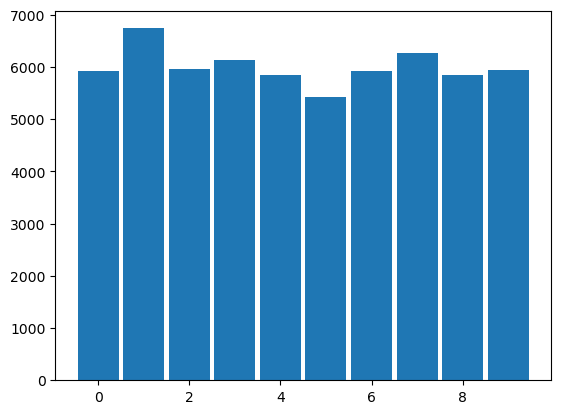

In [5]:
print(x_train.shape)
print(x_test.shape)
plt.hist(y_train, bins=range(11), align='left', rwidth=0.9)


## Normalization

In [6]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

x_train = x_train.reshape(x_train.shape[0], INPUT_SIZE)
x_test = x_test.reshape(x_test.shape[0], INPUT_SIZE)

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Tensorflow Model

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# from keras import Model

# class Model_T1(Model):
#     def __init__(self):
#         super().__init__()

#         self.L1 = Dense(
#                         200,
#                         activation='relu',
#                         kernel_initializer='he_normal')

#         self.L2 = Dense(
#                         150,
#                         activation='relu',
#                         kernel_initializer='he_normal')
#         self.L3 = Dense(100,
#                         activation='relu',
#                         kernel_initializer='he_normal')
#         self.L4 = Dense(
#                         NUM_CLASSES,
#                         activation='softmax',
#                         kernel_initializer='he_normal')
    
#     def call(self, inputs, training=False):
#         x = self.L1(inputs)
#         x = self.L2(x)
#         x = self.L3(x)
#         x = self.L4(x)
#         return x

# model = Model_T1()


model_tf_1 = Sequential()
model_tf_1.add(Dense(
        units=128,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=64,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=32,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=NUM_CLASSES,
        activation='softmax',
        kernel_initializer='he_normal'
))


model_tf_1.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

result = model_tf_1.fit(
            x=x_train,
            y=y_train,
            epochs=3,
            validation_data=(x_test, y_test),
            batch_size=16
)
        

Epoch 1/3
3750/3750 [==============================] - 30s 8ms/step - loss: 0.3212 - accuracy: 0.8997 - val_loss: 0.1492 - val_accuracy: 0.9540
Epoch 2/3
3750/3750 [==============================] - 44s 12ms/step - loss: 0.1719 - accuracy: 0.9467 - val_loss: 0.1409 - val_accuracy: 0.9563
Epoch 3/3
3750/3750 [==============================] - 44s 12ms/step - loss: 0.1397 - accuracy: 0.9567 - val_loss: 0.1377 - val_accuracy: 0.9590


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# 3. Convert data to PyTorch tensors using torch.from_numpy()
x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
y_train_torch = torch.from_numpy(y_train).long()
y_test_torch = torch.from_numpy(y_test).long()

class PyTorchModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(INPUT_SIZE, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, NUM_CLASSES)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)  # No activation, CrossEntropyLoss will take care of it
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)

model_torch_1 = PyTorchModel_1()
model_torch_1.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch_1.parameters(), lr=0.001)


train_dataset = TensorDataset(x_train_torch, y_train_torch)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

time_point = time.time()

for epoch in range(3):  # Number of epochs
    model_torch_1.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_torch_1(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')

    # Validation phase
    model_torch_1.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0

    with torch.no_grad():  # Inference without gradient calculationS
        total += y_test_torch.size(0)
        outputs = model_torch_1(x_test_torch)
        
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_test_torch).sum().item()

    print(f'Epoch {epoch + 1}, Validation Accuracy: {100 * correct / total}%,\
          Time: {time.time() - time_point:.2f} sec')



Epoch 1, Training Loss: 0.3400017791629458
Epoch 1, Validation Accuracy: 93.84%,          Time: 11.70 sec
Epoch 2, Training Loss: 0.183395665759764
Epoch 2, Validation Accuracy: 95.38%,          Time: 19.37 sec
Epoch 3, Training Loss: 0.14475809848809926
Epoch 3, Validation Accuracy: 95.44%,          Time: 27.43 sec
